# Restricted Boltzmann Machine (RBM) for MNIST

This notebook demonstrates the training of a Restricted Boltzmann Machine (RBM) on the MNIST dataset using PyTorch.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.rbm_v3 import RBM, GaussianBernoulliRBM
from utils.rbm_utils import *
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [36]:
MODEL_TYPE = "RBM"
BATCH_SIZE = 128
N_FEATURES = 28 * 28  # Input dimensions MNIST image size
N_HIDDEN = 256 # Number of hidden units
N_CLASSES = 10
EPOCHS = 50  # Keep low for quick demo
LR = 0.005  # AdamW often works better than SGD for RBMs
K_CD = 1
CLASSIFY_INTERVAL = 2  # Check accuracy every 5 epochs
TRAINING_METHOD = "mle"
FILE_PATH = f"./models/checkpoint/{MODEL_TYPE}_{TRAINING_METHOD}_{EPOCHS}.pth"

## Load and Preprocess MNIST Dataset

We'll load the MNIST dataset using torchvision, convert the images to tensors, and normalize them. Since RBMs work with binary data, we'll binarize the images using a threshold.

In [37]:
train_dataset, test_dataset = MNIST()

if MODEL_TYPE == "RBM":
	# features [60000, 784]
	train_features = (train_dataset.data.view(-1, N_FEATURES).float() / 255.0 > 0.5).float()
	test_features = (test_dataset.data.view(-1, N_FEATURES).float() / 255.0 > 0.5).float()

	# labels [60000]
	train_labels = train_dataset.targets
	test_labels = test_dataset.targets

elif MODEL_TYPE == "GRBM":
	scaler = StandardScaler()
	train_features_flat = (
		train_dataset.data.view(-1, N_FEATURES).float().numpy()
	)
	test_features_flat = test_dataset.data.view(-1, N_FEATURES).float().numpy()

	# Fit on training data ONLY
	scaler.fit(train_features_flat)
	train_features = torch.tensor(
		scaler.transform(train_features_flat), dtype=torch.float32
	)
	test_features = torch.tensor(
		scaler.transform(test_features_flat), dtype=torch.float32
	)

	train_labels = train_dataset.targets
	test_labels = test_dataset.targets
	learn_std_grbm = True  # Learn the std dev
	initial_std_grbm = 1.0  # Start near 1 since data is normalized

train_torch_dataset = data.TensorDataset(train_features, train_labels)
test_torch_dataset = data.TensorDataset(test_features, test_labels)

# DataLoader
train_loader = data.DataLoader(
	train_torch_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
	num_workers=2,
	pin_memory=True,
)
test_loader = data.DataLoader(
	test_torch_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
	num_workers=2,
	pin_memory=True,
)

In [38]:
# plt.figure(figsize=(10, 5))
# for i in range(10):
#     img = train_dataset[i][0].squeeze().numpy()
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(img, cmap="gray")
#     plt.title(f"Label: {train_dataset[i][1]}")
#     plt.axis("off")
# plt.tight_layout()
# plt.show()

## Define RBM Model

Now we'll instantiate our RBM model using the class from `rbm.py`. For MNIST:
- n_visible = 784 (28x28 pixels flattened)
- n_hidden = 256 (a common choice for MNIST)
- training_method = "cd" (contrastive divergence)

In [39]:
if MODEL_TYPE == "RBM":
	rbm = RBM(
		n_visible_features=N_FEATURES,
		n_hidden=N_HIDDEN,
		n_classes=N_CLASSES,
		device=device,
	)
elif MODEL_TYPE == "GRBM":
	rbm = GaussianBernoulliRBM(
		n_visible_features=N_FEATURES,
		n_hidden=N_HIDDEN,
		n_classes=N_CLASSES,
		learn_std=learn_std_grbm,
		initial_std=initial_std_grbm,
	)

print(f"RBM Configuration:")
print(f"Visible units: {N_FEATURES}")
print(f"Hidden units: {N_HIDDEN}")
print(f"Model parameters on device: {next(rbm.parameters()).device}")

Initializing RBM: 784 features, 10 classes, 256 hidden units on device: mps
RBM Configuration:
Visible units: 784
Hidden units: 256
Model parameters on device: mps:0


## Train RBM on MNIST

Now we'll train the RBM using the `train_rbm` method provided in the implementation. We need to ensure that we binarize the MNIST data before feeding it to the RBM.

Loading RBM weights from ./models/checkpoint/RBM_mle_50.pth
RBM weights loaded from ./models/checkpoint/RBM_mle_50.pth
Training History Summary:
Epoch     Free Energy         Recon Err (Feat)    Recon Err (Lbl)     Classification Acc  
------------------------------------------------------------------------------------------
1         212.5540            0.6496              0.0412              N/A                 
6         121.0771            0.4706              0.0235              86.46               
11        112.5185            0.4387              0.0235              N/A                 
16        101.2797            0.4153              0.0213              86.58               
21        101.0704            0.4008              0.0183              N/A                 
26        105.4005            0.3903              0.0165              87.38               


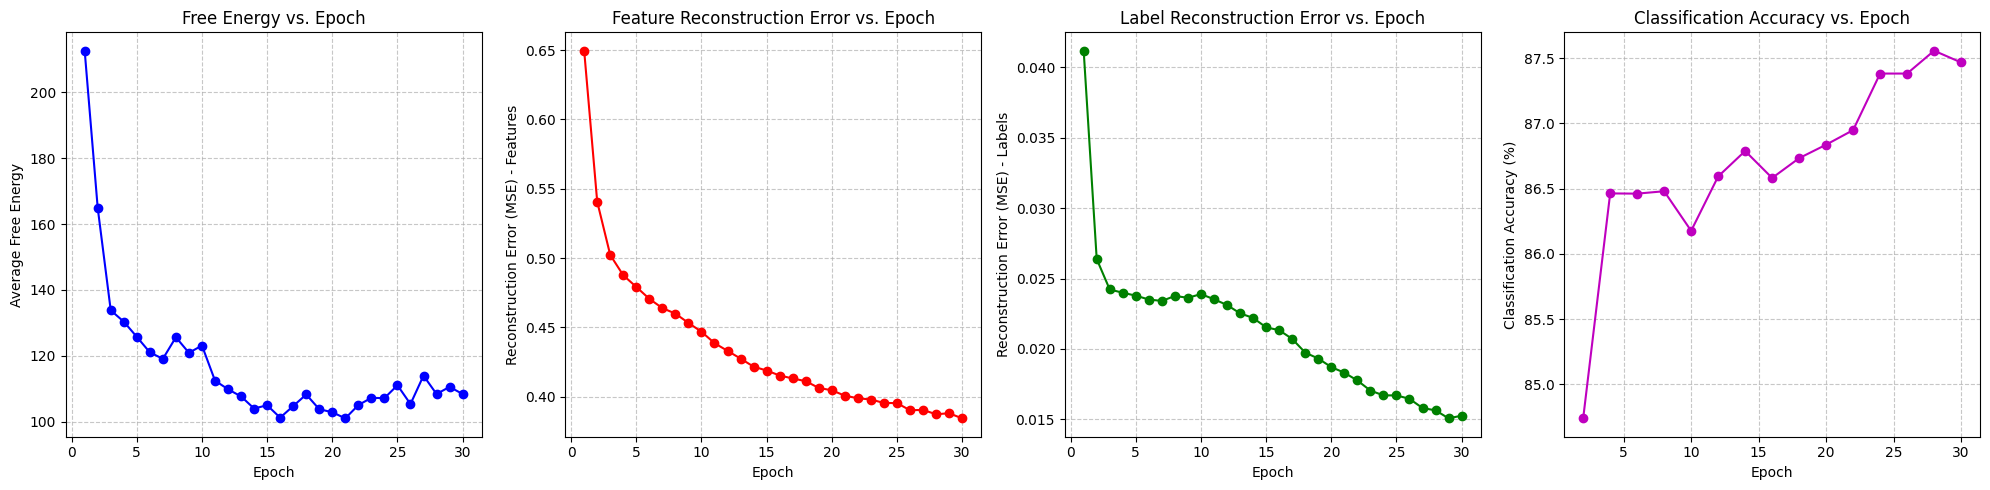


Overall Improvements:
Free Energy: 48.98%
Reconstruction Error (Features): 40.82%
Reconstruction Error (Labels): 62.92%
Classification Accuracy: 2.73%


In [40]:
if os.path.exists(FILE_PATH):
	print(f"Loading RBM weights from {FILE_PATH}")
	rbm.load_state_dict(torch.load(FILE_PATH))
	rbm.eval()  # Set the model to evaluation mode
	print(f"RBM weights loaded from {FILE_PATH}")
else:
	history = rbm.train_rbm(
		train_loader,
		training_method=TRAINING_METHOD,
		lr=LR,
		k=K_CD,
		epochs=EPOCHS,
		record_metrics=True,
		weight_decay=1e-4,
		classification_interval=CLASSIFY_INTERVAL,
	)
	
	torch.save(rbm.state_dict(), FILE_PATH)
	print(f"RBM weights saved to {FILE_PATH}")

if history:
    visualize_training_history(history)

## Reconstructions

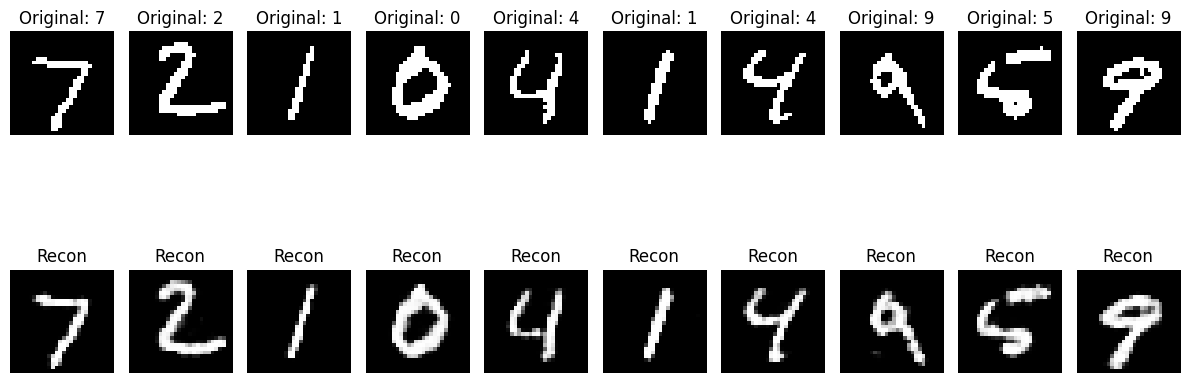

In [41]:
visualize_reconstructions(rbm, test_loader, device=device, n_samples=10)

## Generate Samples by label

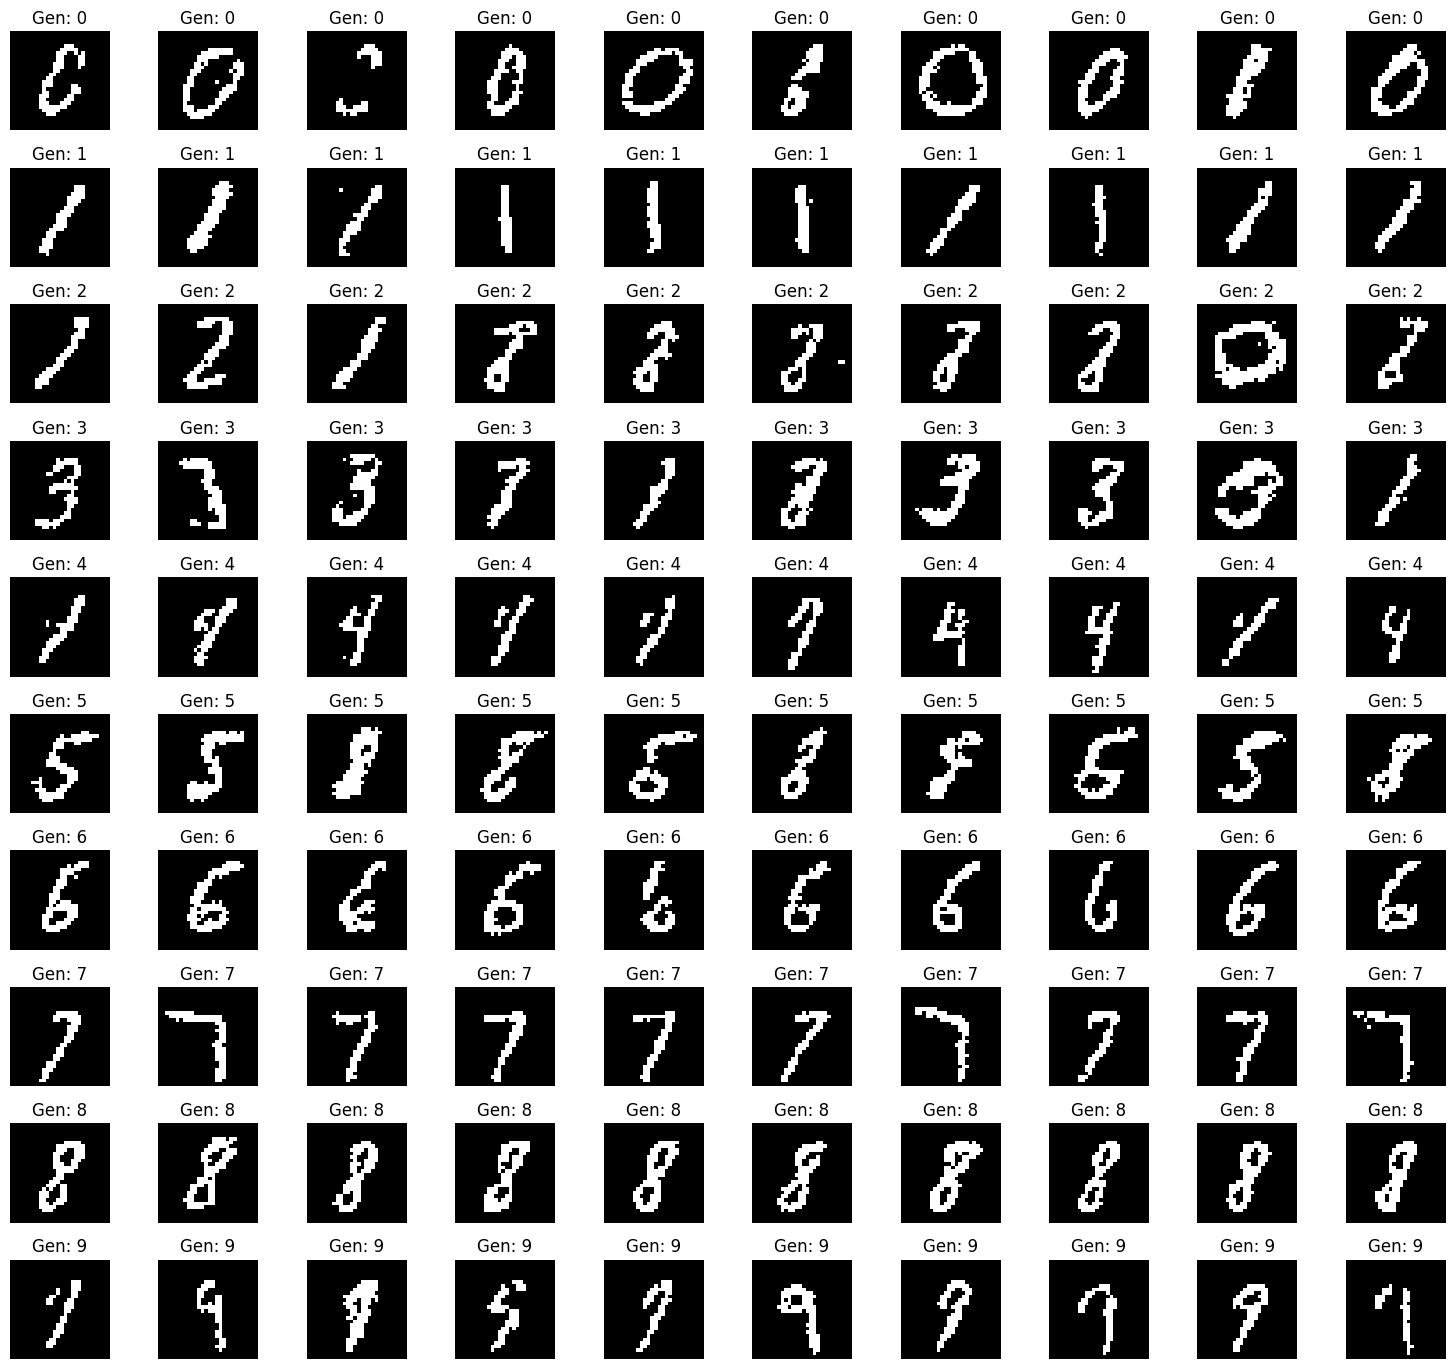

In [42]:
n_generate_per_class = 10
fig, axes = plt.subplots(
    N_CLASSES,
    n_generate_per_class,
    figsize=(n_generate_per_class * 1.5, N_CLASSES * 1.5),
)
# fig.suptitle(f"RBM Generated Samples by Label", fontsize=16)

for digit in range(N_CLASSES):
    generated_features = rbm.generate(
        target_label=digit,
        n_samples=n_generate_per_class,
        gibbs_steps=1000,  # More steps for better samples
    )
    
    if MODEL_TYPE == "GRBM" and "scaler" in locals():
        generated_features = torch.tensor(
			scaler.inverse_transform(generated_features.numpy()),
			dtype=torch.float32,
		)
  
    for i in range(n_generate_per_class):
        ax = axes[digit, i]
        img = generated_features[i].view(28, 28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Gen: {digit}")
        ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Classification

In [43]:
print("\nCalculating final classification accuracy on Test Set...")
correct_predictions = 0
total_samples = 0
rbm.eval()
with torch.no_grad():
	for features, labels in test_loader:
		features = features.view(features.size(0), -1)  # Flatten if needed
		predicted_labels = rbm.classify(features)
		correct_predictions += (
			(predicted_labels.cpu() == labels.cpu()).sum().item()
		)
		total_samples += labels.size(0)

if total_samples > 0:
	test_accuracy = (correct_predictions / total_samples) * 100
	print(f"Test Set Classification Accuracy: {test_accuracy:.2f}%")
else:
	print("Could not calculate test accuracy (no samples processed).")


Calculating final classification accuracy on Test Set...
Test Set Classification Accuracy: 94.07%
